In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import torch
import kornia
import numpy as np
import gc
import os
import sys
%matplotlib notebook
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helpers import Trainer
from helpers import Logger
from helpers import Trial
from mibi_dataloader import MIBIData
from modules import SelfSupervisedEstimator
from criteria import SelfSupervisedEstimatorLoss
import utils

In [2]:
# Load the data
main_dir = '/home/hazmat/GitHub/Denoisotron/'
train_dir = main_dir + 'data/traindat/'
test_dir = main_dir + 'data/testdat/'

modl_dir = main_dir + 'models/'
rslt_dir = main_dir + 'results/'

# train_ds = MIBIData(folder=train_dir, crop=31, scale=1, stride=8, number=10000)
test_ds = MIBIData(folder=test_dir, crop=31, scale=1, stride=8)
lambda_ds = MIBIData.depickle('/home/hazmat/GitHub/Denoisotron/data/large_lambda_ds')

Loading.......99.65277777777777%%3844
There are  4428288 samples


In [3]:
# def l_est(samples, bs, ts):
#     l_ests = torch.zeros(samples.shape)
#     for i in range(samples.size(0)):
#         l_ests[i,:,:,:], cimg = utils.estimate_lambda(samples[i,0,:,:], bs, ts)
#         print('\rProcessing.......' + str(100 * i / samples.size(0)) + '%', end='')
#     return l_ests

# bs = [10];
# while bs[-1]>.7:
#     bs.append(bs[-1]*0.8)

# ts = torch.tensor(bs).float()**-2
# bs = np.array(bs)
# ts = ts.numpy()

# l_images = l_est(train_ds.images, bs, ts)

# lambda_ds = MIBIData(images=l_images, labels='None', source=train_ds.source, crop=31, scale=1, stride=8)
# lambda_ds.pickle('/home/hazmat/GitHub/Denoisotron/data/large_lambda_ds')

In [4]:
estimator_args = dict()
# estimator_args['kdims'] =  [15]
# estimator_args['nfilts'] = [0]

torch.cuda.empty_cache()
# estimator = LambdaEstimator(**estimator_args)
# estimator = LambdaEstimator.load_model(main_dir + 'estimator/models/estimator_saves/', 'model_109')
# estimator = SelfSupervisedEstimator(**estimator_args)
estimator = SelfSupervisedEstimator.load_model(main_dir + 'estimator/models/estimator_saves/', 'amazing_model')

estimator.cuda()
estimator_logger = Logger(['loss'])
estimator_trainer = Trainer()

In [5]:
# Estimator training parameters
estimator_train_args = dict()
estimator_train_args['lr'] = 0.0001
estimator_train_args['batch_size'] = 100
estimator_train_args['epochs'] = 100
estimator_train_args['report'] = 5
estimator_train_args['crop'] = 121
estimator_train_args['clip'] = 1
estimator_train_args['decay'] = 0
estimator_train_args['restart'] = False
estimator_train_args['epoch_frac'] = 1
# estimator_train_args['error_target'] = 0.4
# estimator_train_args['decay'] = 1e-5

# Estimator loss parameters
estimator_criterion = SelfSupervisedEstimatorLoss()

lambda_ds.set_crop(estimator_train_args['crop'])

# estimator.noise = torch.tensor(1)

2304


In [ ]:
estimator.cuda()
estimator_train_args['continue'] = True
estimator_trainer.train(estimator, lambda_ds, estimator_criterion, estimator_logger, main_dir + 'estimator/models/', **estimator_train_args)
# print(estimator.noise)

In [ ]:
# filt_fig = plt.figure()
# filt = estimator.filters[10].lambda_estimator.conv.weight.cpu().detach()[0,0,:,:]
# print(torch.sum(filt))
# plt.imshow(filt)

In [119]:
import re

def get_label(string):
    parts = re.split('_|\.', string)
    return parts[1]

label_dict = {}
for i in range(len(test_ds.source)):
    label = get_label(test_ds.source[i])
    if label in label_dict:
        label_dict[label].append(i)
    else:
        label_dict[label] = [i]

<IPython.core.display.Javascript object>


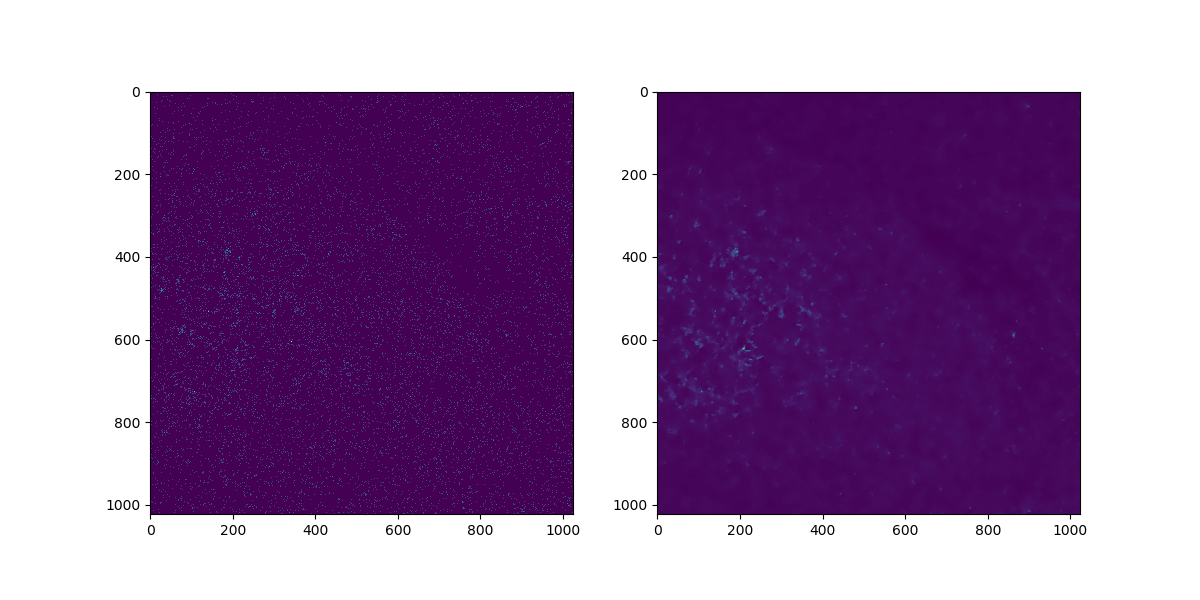

In [148]:
estimator.cuda()
fig = plt.figure(figsize=(12,6))
data = test_ds.images[271].unsqueeze(0)
lamd = estimator.process(data.cuda())
ax1 = plt.subplot(1,2,1)
plt.imshow(data[0,0,:,:].cpu().detach())
ax2 = plt.subplot(1,2,2, sharex=ax1, sharey=ax1)
plt.imshow(lamd[0,0,:,:].cpu().detach())

In [ ]:
# AABAAAAPoint1_3_Abeta40.tif
# print(train_ds.source[1])
data = train_ds.images[2].unsqueeze(0).cuda()
l_hat = estimator.process(data)
l_hat[l_hat<0]=0
resample = torch.tensor(np.random.poisson(l_hat.cpu().detach().numpy()))

In [ ]:
# we need to specify a model
# we should sample multiple times at each model, on each iteration, for each sample

def get_data_even(dataset, label_dict):
    avoid_label = ['Au', 'Background', 'C', 'Ca', 'Fe', 'Na', 'Si', 'Ta', 'totalIon']
    idxs = list()
    for label in label_dict.keys():
        if not any(label==avoid for avoid in avoid_label):
            idx = np.random.choice(label_dict[label])
            idxs.append(idx)
    data = torch.tensor(dataset.images[idxs])
    return data.cuda()
            
# randomly pick some data
def get_data(dataset, n):
    idxs = np.random.permutation(len(dataset.images))
    idxs = idxs[0:n]
    data = torch.tensor(dataset.images[idxs])
    return data.cuda()

def gdt_estimator(samples, **kwargs):
    bs = kwargs['bs']
    ts = kwargs['ts']
    l_ests = torch.zeros(samples.shape)
    for i in range(samples.size(0)):
        l_ests[i,:,:,:], cimg = utils.estimate_lambda(samples[i,0,:,:], bs, ts)
    return l_ests

def net_estimator(samples, **kwargs):
    net = kwargs['network']
    l_ests = torch.zeros(samples.shape)
    for i in range(samples.size(0)):
        l_ests[i,:,:,:] = net.process(samples[i,0,:,:].unsqueeze(0).unsqueeze(0))
    return l_ests

def stupid_estimator(samples, **kwargs):
    l_ests = torch.zeros(samples.shape)
    for i in range(samples.size(0)):
        l_ests[i,:,:,:] = torch.tensor(samples[i,:,:,:])
    return l_ests

def naive_estimator(samples, **kwargs):
    blur = kwargs['blur']
    l_ests = torch.zeros(samples.shape)
    for i in range(samples.size(0)):
        l_ests[i,:,:,:] = utils.imgaussfilt(samples[i,0,:,:], blur).unsqueeze(0).unsqueeze(0)
    return l_ests

def iterated_test(data, n_iters, estimator_function, **kwargs):
    msecrit = torch.nn.MSELoss()
    rdata = torch.tensor(data).cpu()
    error_hist = list()
    l_est_hist = list()
    rdata_hist = list()
    
    for i in range(n_iters):
        l_est = estimator_function(rdata, **kwargs).cpu()
        l_est_hist.append(l_est)
        loss = msecrit(l_est, data)
        error_hist.append(loss.item())
        rdata = torch.poisson(l_est.detach()).cpu()
        rdata_hist.append(rdata)
        print('   ', i)
        
    results = {}
    results['data'] = data
    results['error_hist'] = error_hist
    results['l_est_hist'] = l_est_hist
    results['rdata_hist'] = rdata_hist
    
    return results
    


bs = [10];
while bs[-1]>.7:
    bs.append(bs[-1]*0.8)
ts = torch.tensor(bs).float()**-2
bs = np.array(bs)
ts = ts.numpy()

estimator.eval()
estimator.cpu()
data = get_data_even(test_ds, label_dict).cpu()
n_iters = 20

print('running stupid_estimator...')
stupid_estimator_results = iterated_test(data, n_iters, stupid_estimator)
print()
print('running naive_estimator with blur=1...')
naive_estimator_1_results = iterated_test(data, n_iters, naive_estimator, blur=1)
print()
print('running naive_estimator with blur=5...')
naive_estimator_5_results = iterated_test(data, n_iters, naive_estimator, blur=5)
print()
print('running naive_estimator with blur=20...')
naive_estimator_20_results = iterated_test(data, n_iters, naive_estimator, blur=20)
print()
print('running gdt_estimator...')
gdt_estimator_results = iterated_test(data, n_iters, gdt_estimator, bs=bs, ts=ts)
print()
print('running net_estimator...')
net_estimator_results = iterated_test(data, n_iters, net_estimator, network=estimator)
print()
print('Done')

        
# estimator.eval()
# estimator.cpu()
# msecrit = torch.nn.MSELoss()
# data = get_even_data(test_ds, label_dict).cpu()
# n_iters = 20
# r_data_1 = torch.tensor(data).cpu();
# r_data_2 = torch.tensor(data).cpu();
# error_1 = list()
# error_2 = list()
# data_hist_1 = list()
# data_hist_2 = list()
# est_hist_1 = list()
# est_hist_2 = list()

# for i in range(n_iters):
#     r_data_1 = gdt_estimator(r_data_1.cpu(), bs, ts).cpu()
#     r_data_2 = net_estimator(r_data_2, estimator).cpu()
#     est_hist_1.append(r_data_1)
#     est_hist_2.append(r_data_2)
#     # mean_val = torch.mean(r_data)
#     loss_1 = msecrit(r_data_1, data)
#     loss_2 = msecrit(r_data_2, data)
    
#     error_1.append(loss_1.item())
#     error_2.append(loss_2.item())
    
#     r_data_1 = torch.poisson(r_data_1.detach()).cpu()
#     r_data_2 = torch.poisson(r_data_2.detach()).cpu()
#     print(i)

/home/hazmat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/home/hazmat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/hazmat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


running stupid_estimator...
    0
    1
    2
    3
    4
    5
    6
    7
    8
    9
    10
    11
    12
    13
    14
    15
    16
    17
    18
    19

running naive_estimator with blur=1...
    0
    1
    2
    3
    4
    5
    6
    7
    8
    9
    10
    11
    12
    13
    14
    15
    16
    17
    18
    19

running naive_estimator with blur=5...
    0
    1
    2
    3
    4
    5
    6
    7
    8
    9
    10
    11
    12
    13
    14
    15
    16
    17
    18
    19

running naive_estimator with blur=20...
    0
    1
    2
    3
    4
    5
    6
    7
    8
    9
    10
    11
    12
    13
    14
    15
    16
    17
    18
    19

running gdt_estimator...


/home/hazmat/GitHub/Denoisotron/utils.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data)


    0
    1
    2
    3
    4
    5
    6
    7
    8
    9
    10
    11
    12
    13
    14
    15
    16
    17
    18
    19

running net_estimator...


[0.06188931688666344, 0.06753994524478912, 0.06989891082048416]

<IPython.core.display.Javascript object>


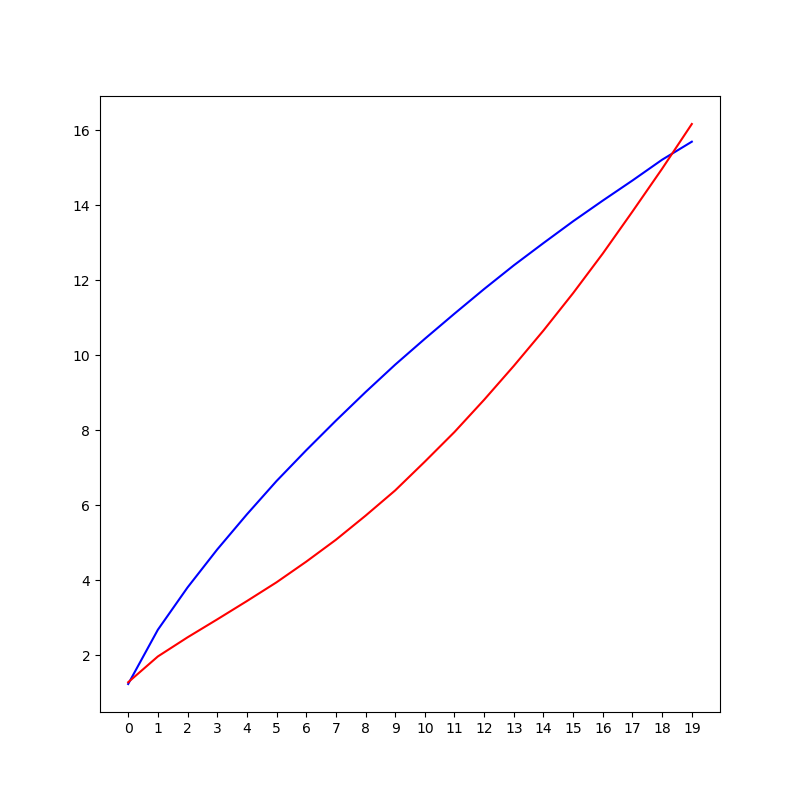

([<matplotlib.axis.XTick at 0x7f39d82010b8>,
 <a list of 20 Text xticklabel objects>)

In [39]:
iter_fig = plt.figure(figsize=(8,8))
plt.plot(error_1, color='blue')
plt.plot(error_2, color='red')
plt.xticks(range(20))

In [ ]:
data_path = '/home/hazmat/GitHub/Denoisotron/data/shirley_point/TIFs/CD45.tif'
data = io.imread(data_path).astype(int)
data = torch.tensor(data, dtype=torch.uint8).float()

In [ ]:
bs = [10];
while bs[-1]>.7:
    bs.append(bs[-1]*0.8)

ts = torch.tensor(bs).float()**-2
bs = np.array(bs)
ts = ts.numpy()
print(bs)
print(ts)

In [ ]:
lambda_est, c_img = utils.estimate_lambda(data, bs, ts)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(lambda_est)